In [35]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.draw import line, circle_perimeter, line_aa, ellipse_perimeter
from skimage.feature import canny
import copy
from math import atan2
from skimage.transform import resize
from image_transformations import *
from time import time

In [36]:
def plot_grayscale_pic(picture, fig_width=7, fig_length=7):
    plt.figure(figsize=(fig_width,fig_length))
    plt.imshow(picture, cmap=plt.get_cmap("gray"), vmin=0.0, vmax=1.0)
    plt.show()
    
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

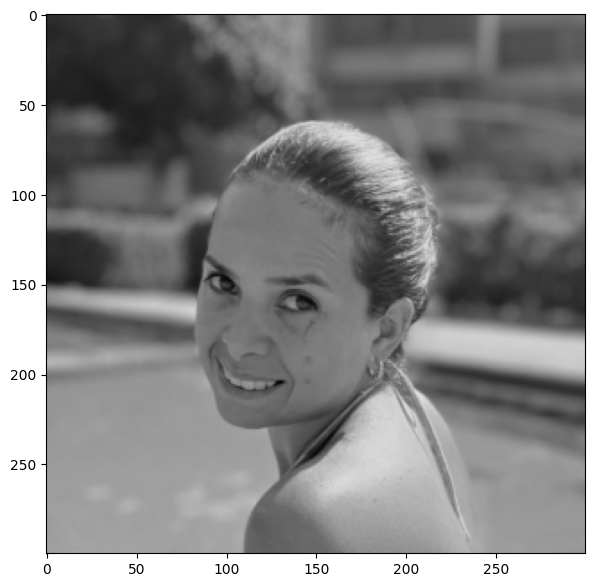

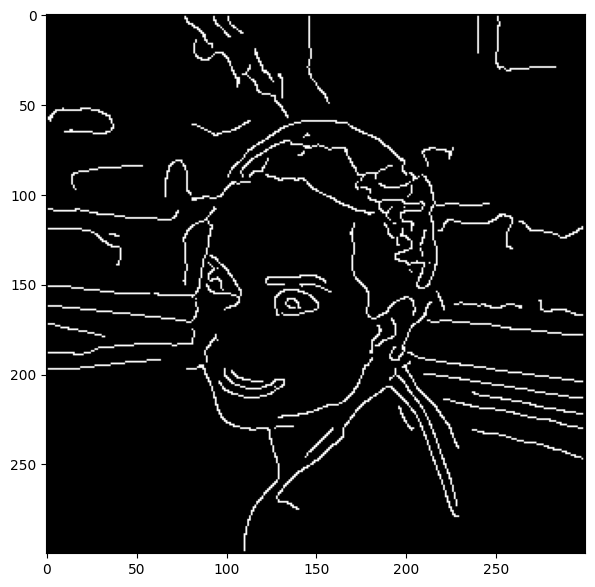

In [37]:
LONG_SIDE = 300

img = mpimg.imread("ale2.jpg")
img = largest_square(img)
img = resize(img, (LONG_SIDE, LONG_SIDE))

orig_pic = rgb2gray(img)

edges = canny(orig_pic, sigma=2)
# orig_pic[edges] = 0.3
orig_pic = orig_pic*0.9

plot_grayscale_pic(orig_pic)
plot_grayscale_pic(edges)

In [38]:
orig_pic[0][:5]

array([0.19494542, 0.19156371, 0.18893483, 0.19133026, 0.19234747])

In [39]:
def create_rectangle_nail_positions(picture, nail_step=2):
    height = len(picture)
    width = len(picture[0])
    
    nails_top = [(0, i) for i in range(0, width, nail_step)]
    nails_bot = [(height-1, i) for i in range(0, width, nail_step)]
    nails_right = [(i, width-1) for i in range(1, height-1, nail_step)]
    nails_left = [(i, 0) for i in range(1, height-1, nail_step)]
    nails = nails_top + nails_right + nails_bot + nails_left
    
    return nails

def create_circle_nail_positions(picture, nail_step=2):
    height = len(picture)
    width = len(picture[0])
    
    centre = (height // 2, width // 2)
    radius = min(height, width) // 2 - 1
    rr, cc = circle_perimeter(centre[0], centre[1], radius)
    nails = list(set([(rr[i], cc[i]) for i in range(len(cc))]))
    nails.sort(key=lambda c: atan2(c[0] - centre[0], c[1] - centre[1]))
    nails = nails[::nail_step]
    
    return nails

def init_black_canvas(picture):
    height = len(picture)
    width = len(picture[0])
    return np.zeros((height, width))

def init_white_canvas(picture):
    height = len(picture)
    width = len(picture[0])
    return np.ones((height, width))

In [40]:
def get_aa_line(from_pos, to_pos, str_strength, picture):
    rr, cc, val = line_aa(from_pos[0], from_pos[1], to_pos[0], to_pos[1])
    line = picture[rr, cc] + str_strength * val
    line = np.clip(line, a_min=0, a_max=1)
    
    return line, rr, cc

def find_best_nail_position(current_position, nails, str_pic, orig_pic, str_strength):

    best_cumulative_improvement = -99999
    best_nail_position = None
    best_nail_idx = None

    for nail_idx, nail_position in enumerate(nails):

        overlayed_line, rr, cc = get_aa_line(current_position, nail_position, str_strength, str_pic)

        before_overlayed_line_diff = np.abs(str_pic[rr, cc] - orig_pic[rr, cc])**2
        after_overlayed_line_diff = np.abs(overlayed_line - orig_pic[rr, cc])**2

        cumulative_improvement =  np.sum(before_overlayed_line_diff - after_overlayed_line_diff)

        if cumulative_improvement >= best_cumulative_improvement:
            best_cumulative_improvement = cumulative_improvement
            best_nail_position = nail_position
            best_nail_idx = nail_idx

    return best_nail_idx, best_nail_position, best_cumulative_improvement

In [41]:
def create_art(nails, orig_pic, str_pic, str_strength):
    
    start = time()
    iter_times = []
    
    current_position = nails[0]
    pull_order = [0]

    i = 0
    while True:
        start_iter = time()
        
        i += 1
        if i > 2500:
            break
        if i % 200 == 0:
            plot_grayscale_pic(str_pic)
        
        idx, best_nail_position, best_cumulative_improvement = find_best_nail_position(current_position, nails,
                                                                                  str_pic, orig_pic, str_strength)
        pull_order.append(idx)
        best_overlayed_line, rr, cc = get_aa_line(current_position, best_nail_position, str_strength, str_pic)
        str_pic[rr, cc] = best_overlayed_line
        
        current_position = best_nail_position
        iter_times.append(time() - start_iter)

    print(f"Time: {time() - start}")
    print(f"Avg iteration time: {np.mean(iter_times)}")
    return pull_order

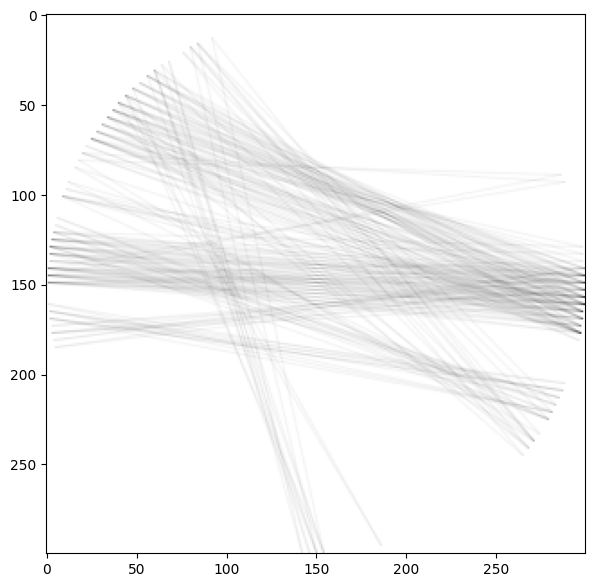

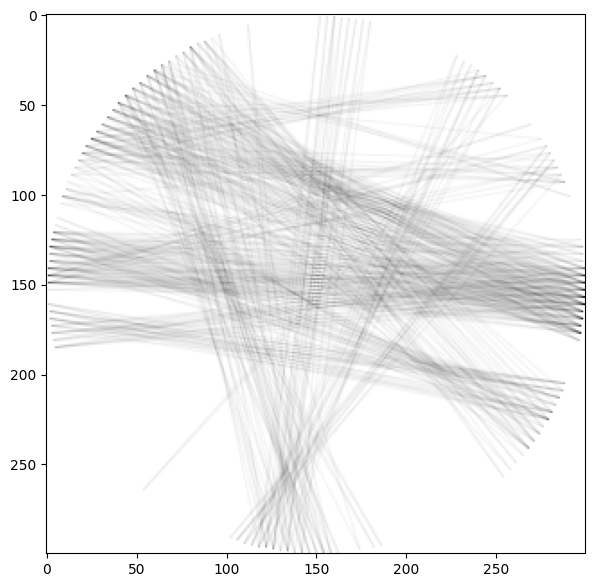

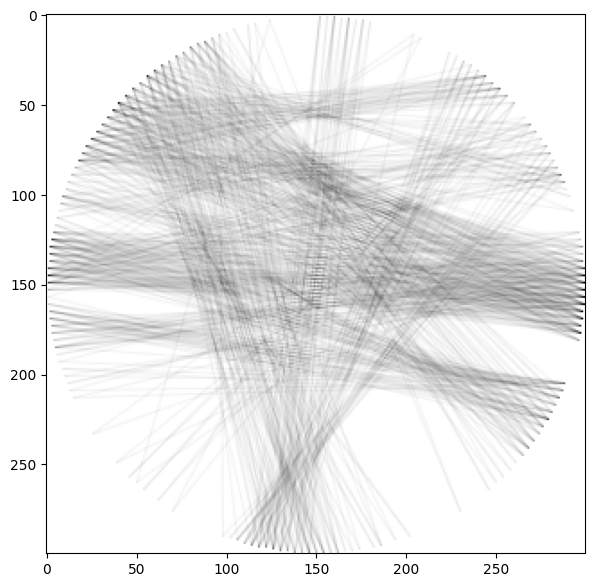

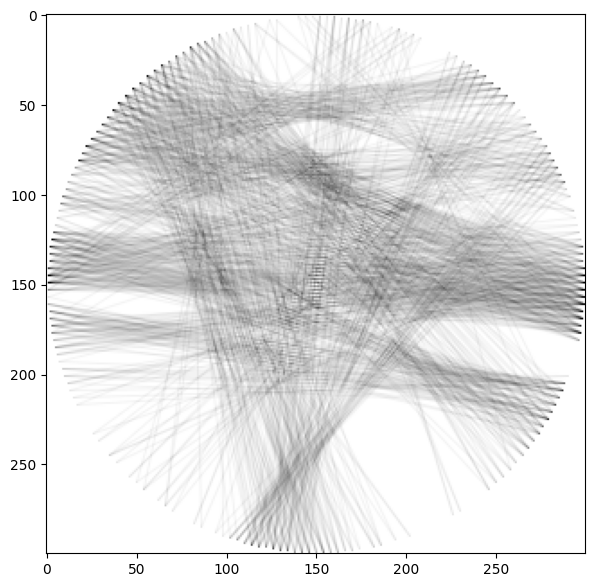

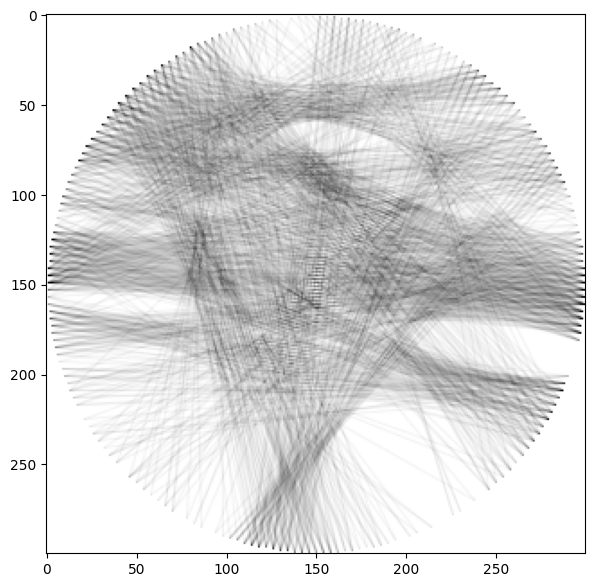

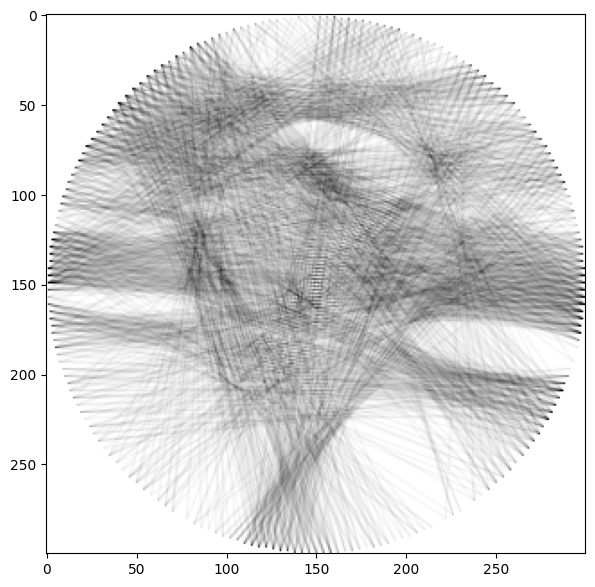

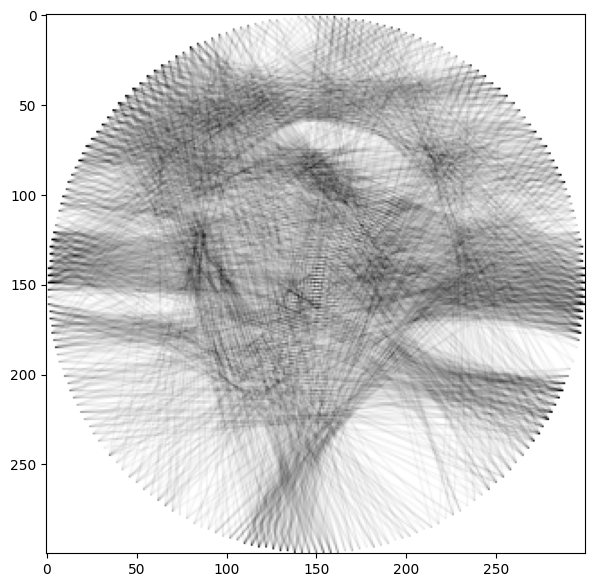

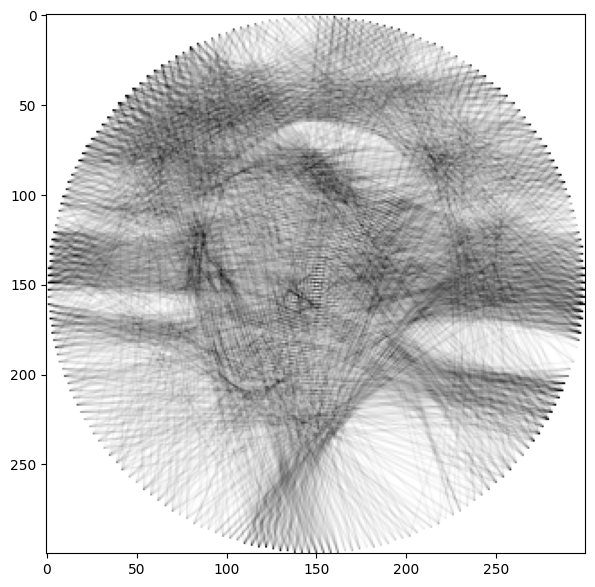

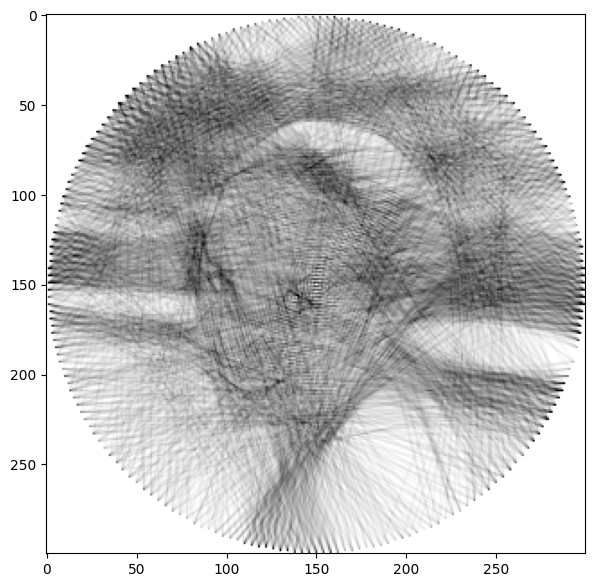

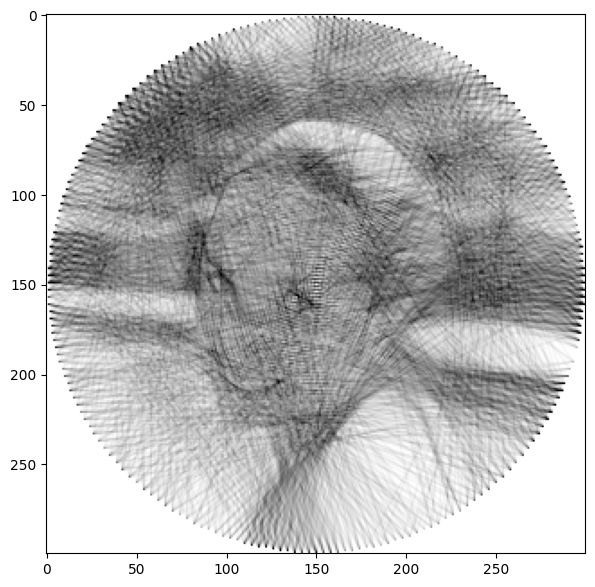

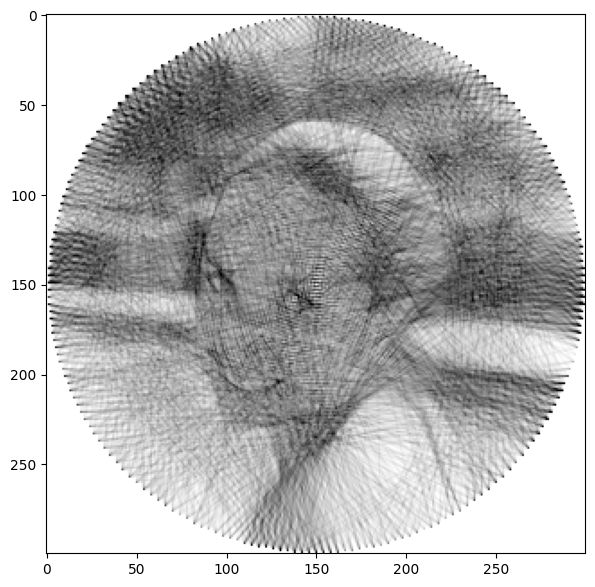

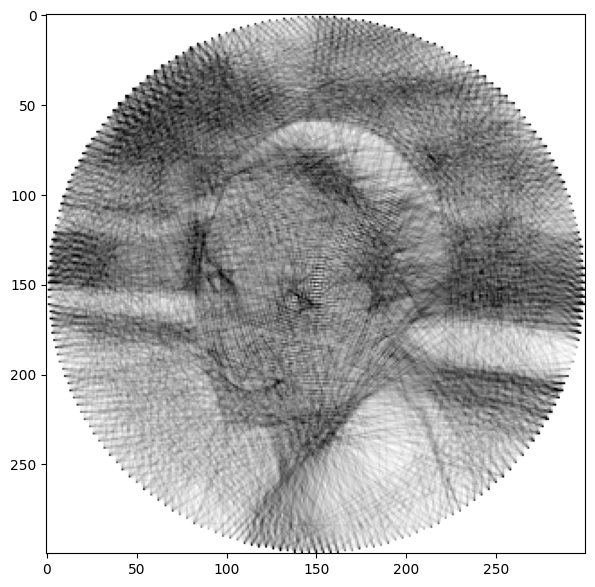

Time: 40.38199758529663
Avg iteration time: 0.01615279903411865


In [42]:
nails = create_circle_nail_positions(orig_pic, 4)
str_pic = init_white_canvas(orig_pic)
pull_order = create_art(nails, orig_pic, str_pic, -0.05)

In [43]:
print(f"Thread pull order by nail index:\n{'-'.join([str(idx) for idx in pull_order])}")

Thread pull order by nail index:
0-108-3-107-2-108-1-106-2-105-0-107-1-109-27-110-5-105-4-109-0-104-5-108-25-107-6-104-203-103-3-109-22-112-29-110-1-111-23-105-24-112-20-109-26-107-4-108-28-111-2-104-25-110-21-108-6-106-27-112-19-111-29-108-0-110-23-103-202-105-7-122-5-106-24-107-22-113-20-110-4-121-6-103-24-127-36-126-16-112-23-106-28-109-5-121-207-120-206-119-207-123-8-124-14-112-18-106-205-105-26-128-35-160-32-159-30-158-29-107-12-109-2-110-24-104-22-108-12-112-21-101-6-105-1-112-30-157-31-127-17-90-1-102-23-128-30-109-21-106-204-108-26-104-7-124-5-107-20-111-0-103-25-149-26-157-38-127-35-123-206-120-208-123-9-122-36-158-27-104-204-107-7-100-20-105-25-129-34-124-12-104-4-111-18-91-2-112-13-108-19-113-29-155-28-105-22-101-5-123-6-109-19-77-167-74-166-75-165-58-164-55-162-56-165-76-168-86-1-83-0-106-202-107-30-162-57-164-54-163-59-161-31-164-28-110-19-78-21-100-6-125-37-128-18-113-28-156-33-160-43-162-72-167-73-163-27-128-25-150-26-103-5-111-3-121-7-102-20-77-17-91-30-111-12-87-169-88

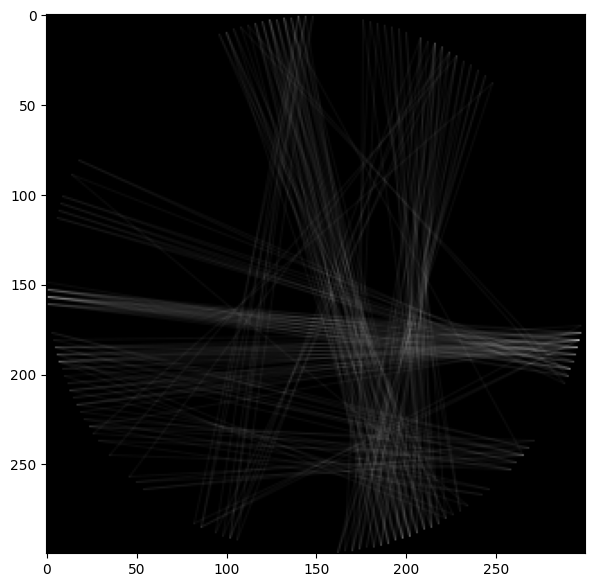

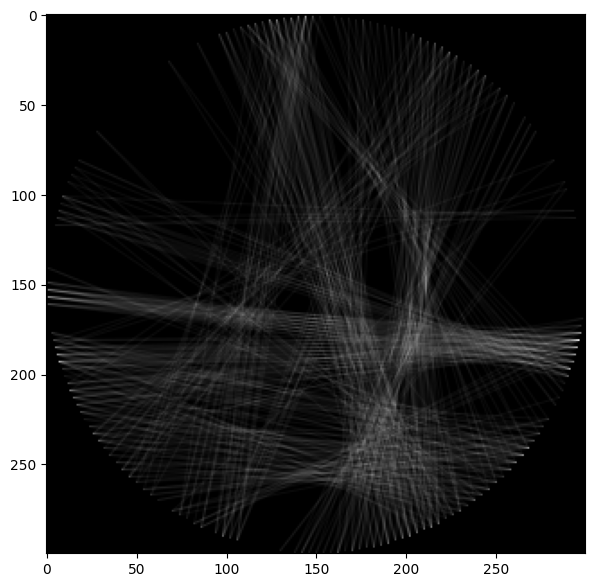

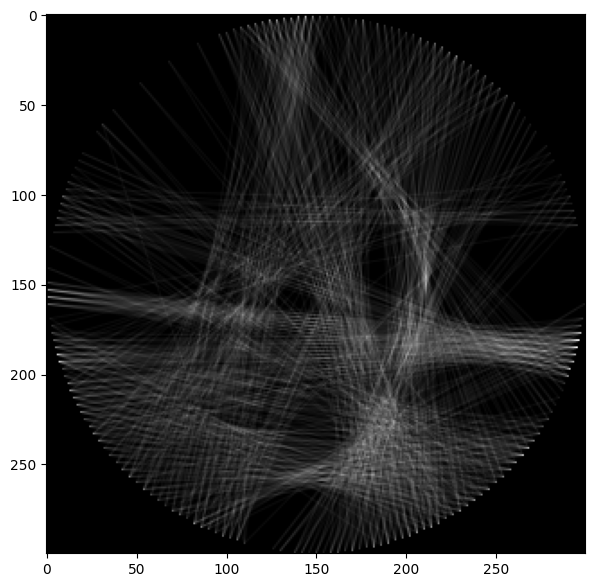

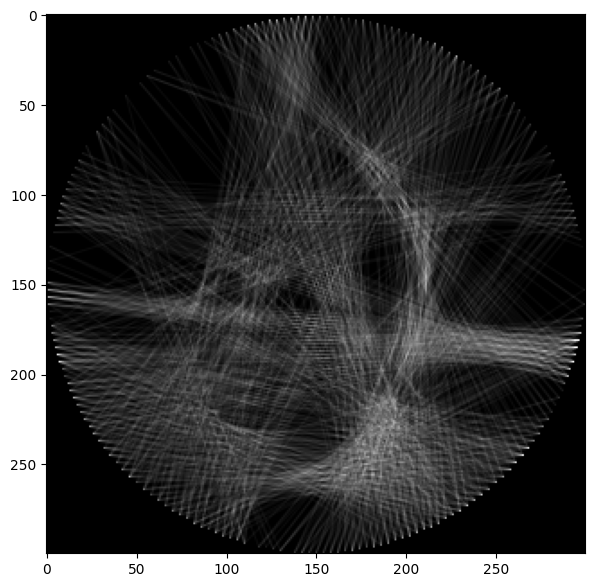

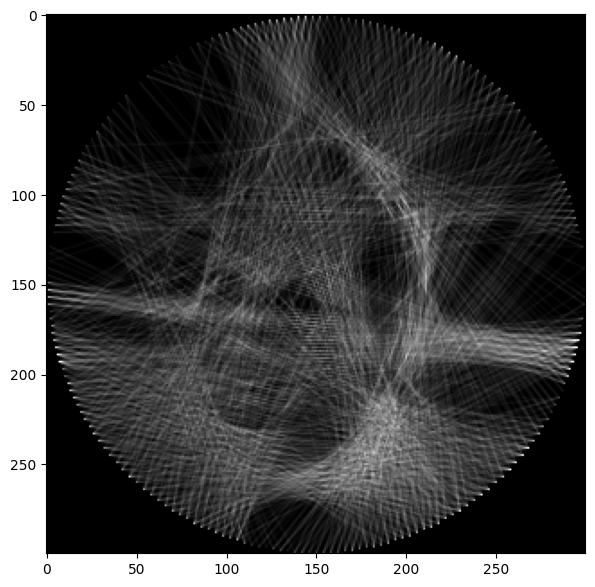

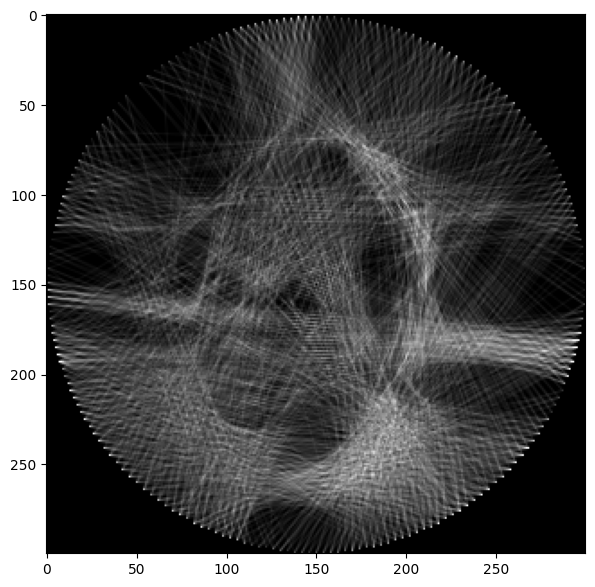

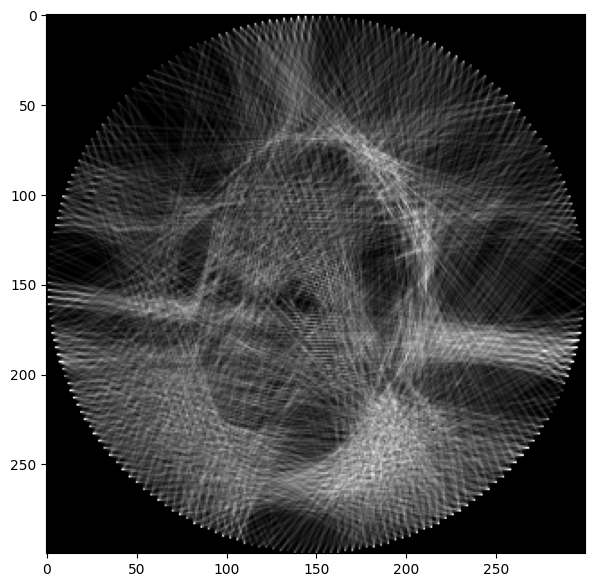

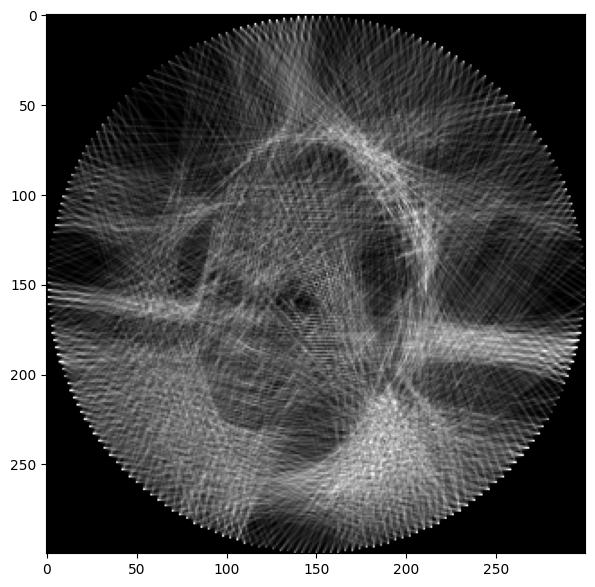

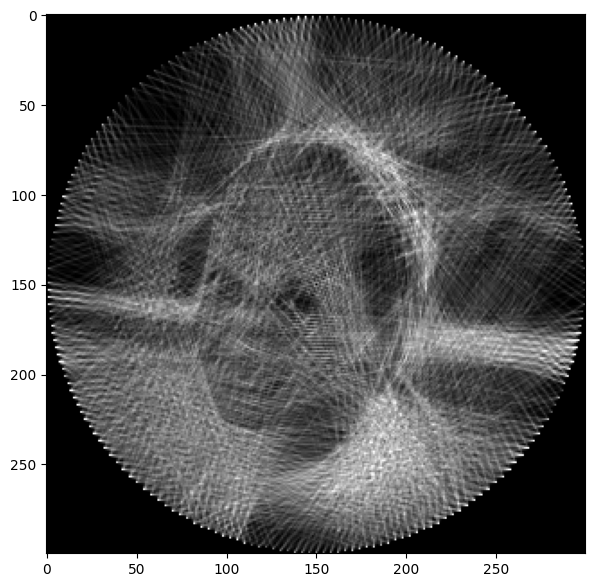

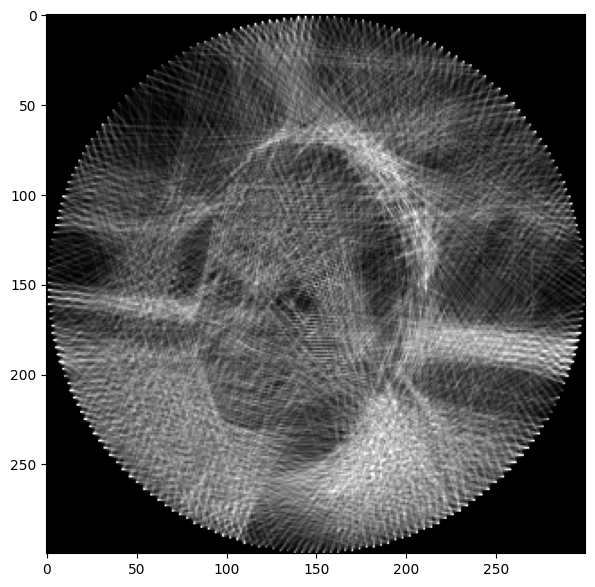

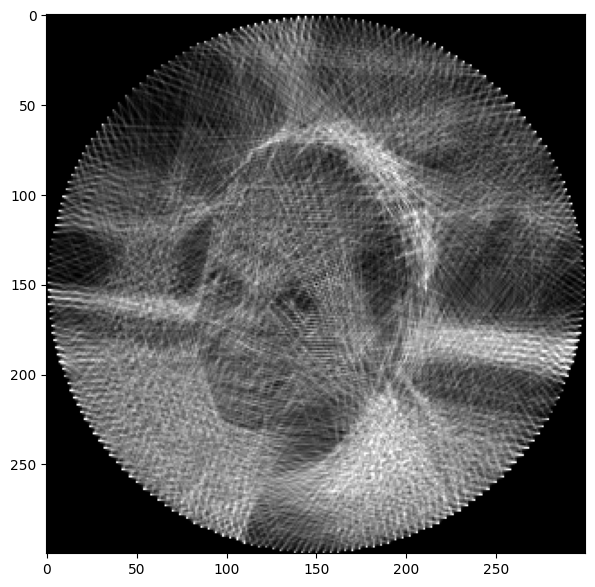

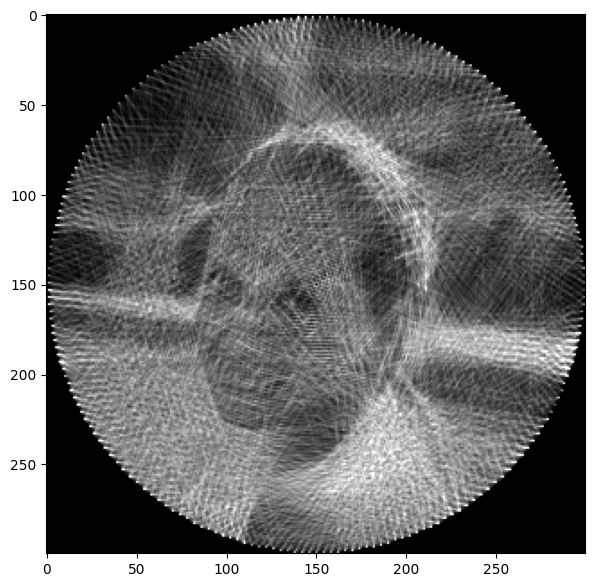

Time: 42.16214203834534
Avg iteration time: 0.016864856815338135


[0,
 117,
 210,
 115,
 209,
 114,
 210,
 116,
 209,
 113,
 200,
 112,
 201,
 114,
 208,
 116,
 209,
 117,
 10,
 118,
 210,
 113,
 201,
 115,
 200,
 114,
 209,
 113,
 196,
 112,
 194,
 113,
 202,
 114,
 197,
 112,
 195,
 113,
 208,
 115,
 210,
 114,
 199,
 113,
 193,
 131,
 194,
 114,
 196,
 134,
 192,
 128,
 203,
 112,
 202,
 130,
 201,
 139,
 39,
 142,
 46,
 146,
 48,
 144,
 45,
 147,
 46,
 143,
 47,
 145,
 69,
 148,
 45,
 145,
 49,
 144,
 69,
 149,
 72,
 151,
 73,
 149,
 47,
 146,
 70,
 152,
 75,
 153,
 69,
 171,
 51,
 148,
 44,
 141,
 40,
 144,
 64,
 141,
 61,
 153,
 74,
 150,
 46,
 148,
 49,
 143,
 63,
 142,
 67,
 146,
 50,
 170,
 51,
 175,
 113,
 191,
 129,
 204,
 128,
 182,
 129,
 202,
 115,
 209,
 118,
 11,
 117,
 208,
 112,
 209,
 117,
 12,
 116,
 9,
 117,
 15,
 137,
 198,
 113,
 174,
 50,
 145,
 70,
 170,
 67,
 150,
 48,
 147,
 71,
 152,
 59,
 142,
 65,
 140,
 200,
 111,
 174,
 52,
 169,
 68,
 147,
 40,
 140,
 41,
 146,
 44,
 149,
 43,
 119,
 17,
 118,
 42,
 145,
 48,
 129,
 1

In [44]:
nails = create_circle_nail_positions(orig_pic, 4)
str_pic = init_black_canvas(orig_pic)
create_art(nails, orig_pic, str_pic, 0.05)

In [45]:
def scale_nails(x_ratio, y_ratio, nails):
    return [(int(y_ratio*nail[0]), int(x_ratio*nail[1])) for nail in nails]

def circular_pull_order_to_array_bw(order, canvas, nails):
    # Draw a black and white pull order on the defined resolution

    for pull_start, pull_end in zip(order, order[1:]):  # pairwise iteration
        rr, cc, val = line_aa(nails[pull_start][0], nails[pull_start][1],
                              nails[pull_end][0], nails[pull_end][1])
        canvas[rr, cc] += val * -0.1

    return np.clip(canvas, a_min=0, a_max=1)


image_dimens = 900, 900
blank = np.ones((image_dimens[0], image_dimens[1]))
scaled_nails = scale_nails(
    image_dimens[1] / len(orig_pic),
    image_dimens[0] / len(orig_pic[0]),
    nails
)

result = circular_pull_order_to_array_bw(
    pull_order,
    blank,
    scaled_nails
)
mpimg.imsave('output.png', result, cmap=plt.get_cmap("gray"))